In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import numpy as np

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from formulaic import model_matrix

In [2]:
def generar_datos(n=1000, amin=0, amax=20, bmin=5, bmax=20, seed=2906):
    np.random.seed(seed)
    brange = bmax - bmin
    a = stats.uniform.rvs(size=n, loc=amin, scale=amax - amin)
    b = stats.norm.rvs(size=n, loc=bmin + brange / 2, scale=brange / 8)
    eps = stats.norm.rvs(size=n, loc=0, scale=4)
    y = 1 + 3 * a - 2 * b + 1.5 * a * b - 0.8 * a**2 + 0.6 * b**2 + eps
    return pd.DataFrame({"a": a, "b": b}), pd.Series(y)


X, y = generar_datos()

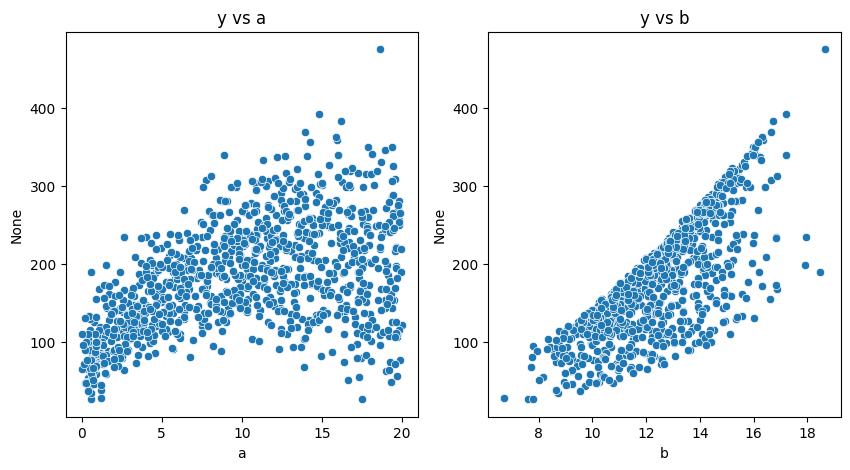

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i, col in enumerate(X):
    sns.scatterplot(x=X[col], y=y, ax=axs[i])
    axs[i].set_title(f"y vs {col}")

In [4]:
test_split = 0.5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)

In [5]:
lr1 = LinearRegression()
lr1.fit(X_train, y_train)

LinearRegression()

In [6]:
beta1 = pd.Series(lr1.coef_, index=X_train.columns)
beta1["intercept"] = lr1.intercept_
beta1

a              5.669493
b             28.625644
intercept   -232.750494
dtype: float64

In [7]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [8]:
y_pred = lr1.predict(X_test)
print(
    "# RMSE",
    f"Train: {rmse(lr1.predict(X_train), y_train):.4f}",
    "Test:  %.4f" % rmse(y_pred, y_test),
    sep="\n",
)

# RMSE
Train: 29.4463
Test:  30.6580


In [9]:
pd.Series(y_pred, name="y_pred")

0      200.451972
1      195.491842
2      104.319812
3       53.971645
4      220.032801
          ...    
495    234.745695
496    149.377942
497    322.516759
498     83.940143
499    133.815613
Name: y_pred, Length: 500, dtype: float64

In [10]:
df_test = pd.concat(
    [
        X_test,
        y_test.rename("y"),
        pd.Series(y_pred, name="y_pred", index=y_test.index),
    ],
    axis=1,
)
df_test

,a,b,y,y_pred
928,0.035305,15.126378,110.858662,200.451972
233,8.245538,13.327013,216.979295,195.491842
62,3.296314,11.122261,112.620254,104.319812
996,6.947835,8.640205,102.264704,53.971645
81,7.996455,14.233652,243.056966,220.032801
...,...,...,...,...
820,13.880597,13.582236,254.315498,234.745695
154,15.078763,10.362719,141.374933,149.377942
266,13.953465,16.633973,369.192792,322.516759
208,17.501605,7.596874,26.988561,83.940143


In [11]:
df_test = X_test.copy()
df_test["y"] = y_test
df_test["y_pred"] = y_pred
df_test["resid"] = df_test["y"] - df_test["y_pred"]
df_test.head()

,a,b,y,y_pred,resid
928,0.035305,15.126378,110.858662,200.451972,-89.593311
233,8.245538,13.327013,216.979295,195.491842,21.487454
62,3.296314,11.122261,112.620254,104.319812,8.300442
996,6.947835,8.640205,102.264704,53.971645,48.293059
81,7.996455,14.233652,243.056966,220.032801,23.024165


### Análisis de residuos

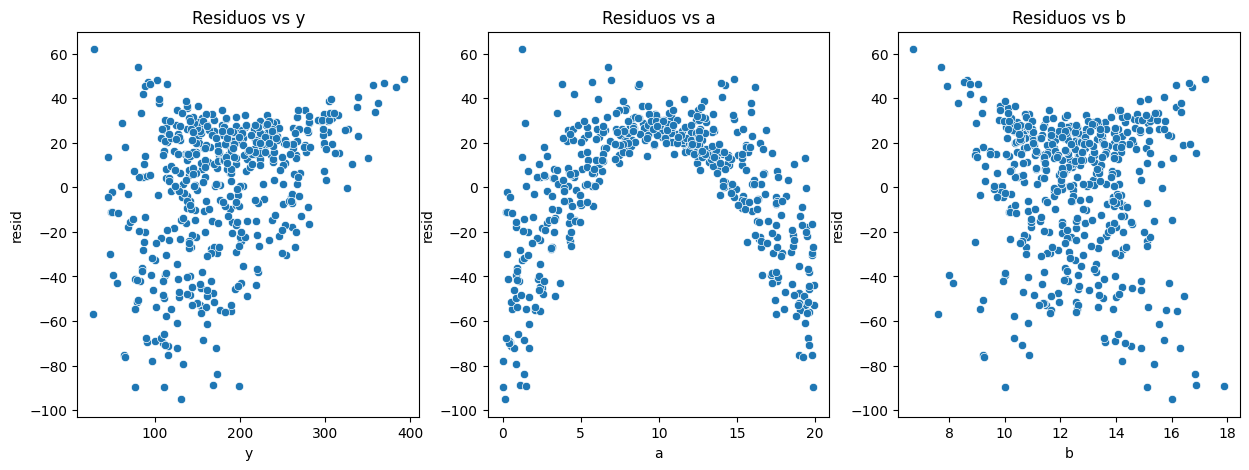

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for versus, ax in zip(["y", "a", "b"], axs.flatten()):
    sns.scatterplot(x=versus, y="resid", data=df_test, ax=ax)
    ax.set_title(f"Residuos vs {versus}")

Pareciera haber alguna relación cuadrática entre los residuos y $a$, entonces...

In [13]:
formula = "~ poly(a, 2, raw=True) * b"
# Como solo tiene RHS, no devuelve $y$
X_train2 = model_matrix(formula, data=X_train)
X_train2.head()
# pueden explicar por qué quedan las columnas que quedas?

,Intercept,"poly(a, 2, raw=True)[0]","poly(a, 2, raw=True)[1]",b,"poly(a, 2, raw=True)[0]:b","poly(a, 2, raw=True)[1]:b"
256,1.0,17.803226,316.954853,13.578825,241.746881,4303.874335
389,1.0,19.582317,383.467139,11.113866,217.635255,4261.802551
947,1.0,3.454193,11.931447,12.936554,44.685348,154.351801
922,1.0,15.339335,235.295211,9.568627,146.776376,2251.452067
463,1.0,16.855792,284.117732,12.440912,209.701423,3534.683617


In [14]:
import re


def nombres_poli(s):
    repl = lambda m: f"{m.group(1)}^{int(m.group(2))+1}"
    nombres = re.sub(r"poly\((\w), \d+, raw=True\)\[(\d)\]", repl, s).replace("^1", "")
    return nombres


np.vectorize(nombres_poli)(X_train2.columns)

array(['Intercept', 'a', 'a^2', 'b', 'a:b', 'a^2:b'], dtype='<U9')

### np.vectorize

In [15]:
assert all(
    np.vectorize(nombres_poli)(X_train2.columns)
    == [nombres_poli(c) for c in X_train2.columns]
)

In [16]:
lr2 = LinearRegression(fit_intercept=False)  # Ya está incluido en model_matrix
lr2.fit(X_train2, y_train)

LinearRegression(fit_intercept=False)

In [17]:
lr2.coef_

array([-1.06261266e+02,  5.94817335e+00, -9.28828345e-01,  1.42689494e+01,
        1.25561285e+00,  1.06662231e-02])

In [18]:
def betas(lr, train):
    beta = pd.Series(lr.coef_, index=train.columns)
    if lr.fit_intercept:
        beta["Intercept"] = lr.intercept_
    beta.index = beta.index.map(nombres_poli)
    return beta


betas(lr2, X_train2)

Intercept   -106.261266
a              5.948173
a^2           -0.928828
b             14.268949
a:b            1.255613
a^2:b          0.010666
dtype: float64

In [19]:
def mostrar_rmse(lr, X_train, y_train, X_test, y_test):
    print(
        "# RMSE",
        f"Train: {rmse(lr.predict(X_train), y_train):.4f}",
        "Test:  %.4f" % rmse(lr.predict(X_test), y_test),
        sep="\n",
    )


mostrar_rmse(lr2, X_train2, y_train, model_matrix(formula, data=X_test), y_test)

# RMSE
Train: 4.7419
Test:  4.8705


In [20]:
y_pred2 = lr2.predict(model_matrix(formula, data=X_test))
df_test = df_test.rename(columns={"y_pred": "y_pred1", "resid": "resid1"})
df_test["y_pred2"] = y_pred2
df_test["resid2"] = df_test["y"] - df_test["y_pred2"]

Text(0.5, 1.0, "93.40% de las observaciones 'ajustan mejor' con lr2")

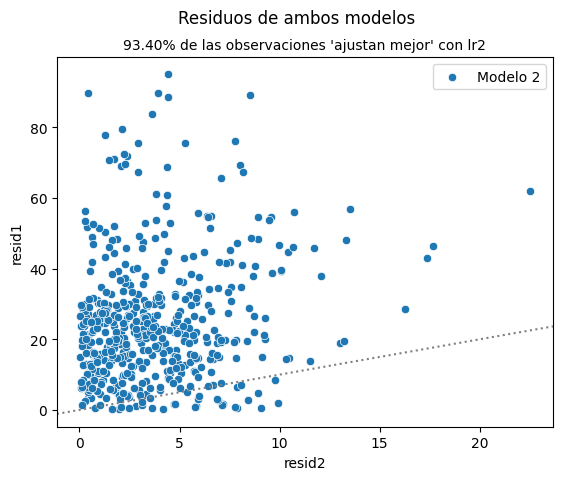

In [21]:
sns.scatterplot(x="resid2", y="resid1", data=df_test.abs(), label="Modelo 2")
plt.axline((0, 0), slope=1, color="gray", linestyle="dotted")
plt.suptitle(f"Residuos de ambos modelos")
perc_mejora = 100 * (df_test.resid2.abs() < df_test.resid1.abs()).mean()
plt.title(
    f"{perc_mejora:.2f}% de las observaciones 'ajustan mejor' con lr2", fontsize=10
)

In [22]:
# Otra manera de calcular RMSE Test
df_test[["resid1", "resid2"]].pow(2).mean().apply(np.sqrt)

resid1    30.657964
resid2     4.870524
dtype: float64

Revisamos otra vez la estructura de los residuos

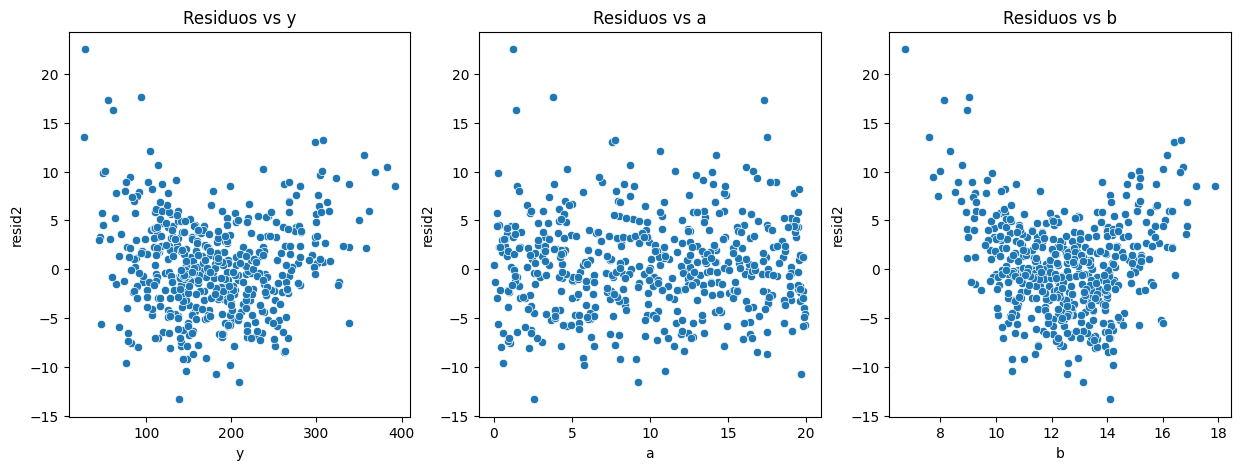

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for versus, ax in zip(["y", "a", "b"], axs.flatten()):
    sns.scatterplot(x=versus, y="resid2", data=df_test, ax=ax)
    ax.set_title(f"Residuos vs {versus}")

$y \sim a$ parece bien capturado, pero aún queda una estructura contra $b$. Será cuadrática también?

In [24]:
formula = "~ 0 + poly(a, 2, raw=True) * poly(b, 2, raw=True)"
X_train3 = model_matrix(formula, data=X_train)
X_train3.shape, np.vectorize(nombres_poli)(X_train3.columns)

((500, 8),
 array(['a', 'a^2', 'b', 'b^2', 'a:b', 'a^2:b', 'a:b^2', 'a^2:b^2'],
       dtype='<U7'))

¿Por qué hay 8 terminos y no $3 \times 3=9$? ¿Se acabará algún día este proceso?

## Regrsión Grieta (AKA Ridge)

Una hipótesis: si le doy suficientes grados de libertad al modelo, y regularizo fuertemente, debería encontrar un modelo simple que ajuste a los datos sin demasiado esfuerzo. Será verdad?

In [25]:
from sklearn.linear_model import Ridge

formula = "~ 0 + poly(a, 3, raw=True) * poly(b, 3, raw=True)"
X_train4 = model_matrix(formula, data=X_train)

lr4 = Ridge(alpha=100)
lr4.fit(X_train4, y_train)

Ridge(alpha=100)

In [26]:
mostrar_rmse(lr4, X_train4, y_train, model_matrix(formula, data=X_test), y_test)

# RMSE
Train: 3.9681
Test:  3.9816


In [27]:
pd.DataFrame({"lr2": betas(lr2, X_train2), "lr4": betas(lr4, X_train4)}).round(4)

,lr2,lr4
Intercept,-106.2613,-2.2260
a,5.9482,0.1217
a:b,1.2556,0.5208
a:b^2,NaN,0.2221
a:b^3,NaN,-0.0099
a^2,-0.9288,-0.0015
a^2:b,0.0107,0.0109
a^2:b^2,NaN,-0.0182
a^2:b^3,NaN,0.0010
a^3,NaN,-0.0417


Nada mal! Pero se podrá mejorar aún más? Cómo encunetro el valor óptimo de la penalización $\alpha$? CV al rescate

## Validación cruzada con scikit-learn
### np.logspace

In [28]:
np.logspace(0, 2, 5)

array([  1.        ,   3.16227766,  10.        ,  31.6227766 ,
       100.        ])

In [29]:
alfas = np.logspace(-3, 3, 61)

In [30]:
alfas[:5].round(5), alfas[-5:].round(3)

(array([0.001  , 0.00126, 0.00158, 0.002  , 0.00251]),
 array([ 398.107,  501.187,  630.957,  794.328, 1000.   ]))

In [31]:
def norma(vec):
    return np.sqrt((vec**2).sum())

In [32]:
assert norma(np.array([3, 4])) == 5

In [33]:
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


rmse_train = {}
rmse_test = {}
beta_norm = {}
intercept = {}
for alfa in alfas:
    ridge = Ridge(alpha=alfa)
    ridge.fit(X_train4, y_train)
    rmse_train[alfa] = rmse(ridge.predict(X_train4), y_train)
    rmse_test[alfa] = rmse(ridge.predict(model_matrix(formula, X_test)), y_test)
    beta_norm[alfa] = norma(ridge.coef_)
    intercept[alfa] = ridge.intercept_

    logger.info(f"Alfa: {alfa.round(3):.3f}")

/Users/gonzalo/Git/ldd/venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.72885e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
INFO:__main__:Alfa: 0.001
/Users/gonzalo/Git/ldd/venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.83338e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
INFO:__main__:Alfa: 0.001
/Users/gonzalo/Git/ldd/venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.96501e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
INFO:__main__:Alfa: 0.002
/Users/gonzalo/Git/ldd/venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.13081e-19): result may not be accurate.
  retur

Fíjense qué interesante: efecivamente para alfas muy pequeños, cuando Ridge es casi igual a la reg. lineal "vainilla", la matrix efectivamente está mal condicionada.

In [34]:
data = pd.DataFrame(
    {
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "beta_norm": beta_norm,
        "intercept": intercept,
    }
).reset_index(names="alfa")

In [35]:
data

,alfa,rmse_train,rmse_test,beta_norm,intercept
0,0.001000,3.938346,3.966341,11.963881,-33.643202
1,0.001259,3.938348,3.966303,11.658779,-33.234450
2,0.001585,3.938351,3.966258,11.298093,-32.750046
3,0.001995,3.938356,3.966207,10.877533,-32.183435
4,0.002512,3.938361,3.966149,10.395023,-31.530667
...,...,...,...,...,...
56,398.107171,3.979031,3.985525,0.405891,1.154346
57,501.187234,3.980254,3.985078,0.392196,1.676910
58,630.957344,3.981451,3.984362,0.381211,2.226824
59,794.328235,3.982701,3.983417,0.371868,2.816419


### Interludio: $\alpha \rightarrow \infty$? 

In [36]:
ridge = Ridge(alpha=1e100)
ridge.fit(X_train4, y_train)
ridge.intercept_

179.90992934392975

### np.isclose

In [37]:
assert np.isclose(y_train.mean(), ridge.intercept_)

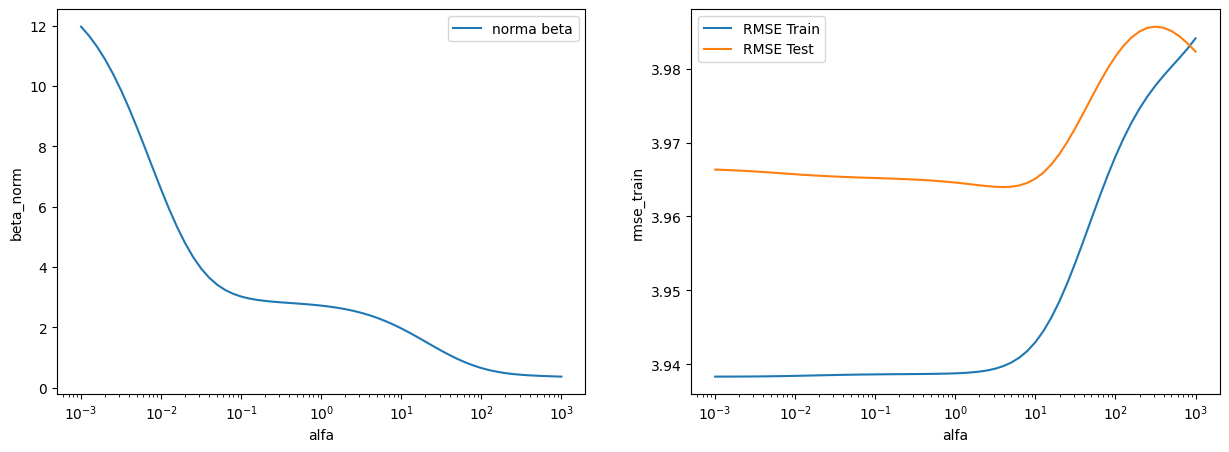

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
sns.lineplot(data=data, x="alfa", y="beta_norm", label="norma beta", ax=axs[0])
# sns.lineplot(data=data, x="alfa", y="intercept", label="intercept", ax=axs[0])
# sns.lineplot(data=data, x="alfa", y="intercept", label="intercept")
sns.lineplot(data=data, x="alfa", y="rmse_train", label="RMSE Train", ax=axs[1])
sns.lineplot(data=data, x="alfa", y="rmse_test", label="RMSE Test", ax=axs[1])
plt.xscale("log")  # Probar comentando esta línea
plt.legend()

In [39]:
optimo = data.iloc[data.rmse_test.idxmin()]
optimo

alfa           3.981072
rmse_train     3.939769
rmse_test      3.963977
beta_norm      2.400377
intercept    -14.060401
Name: 36, dtype: float64

In [40]:
lr4 = Ridge(alpha=optimo.alfa)
lr4.fit(X_train4, y_train)
mostrar_rmse(lr4, X_train4, y_train, model_matrix(formula, X_test), y_test)

# RMSE
Train: 3.9398
Test:  3.9640


In [41]:
betas(lr4, X_train4).abs().sort_values(ascending=False)

Intercept    14.060401
a:b           2.232559
a             0.610618
b^2           0.493366
a^2:b         0.279766
a^2           0.273832
a^3           0.053354
a:b^2         0.051416
b             0.042443
a^2:b^2       0.021896
a^3:b         0.013700
b^3           0.003154
a^3:b^2       0.001096
a:b^3         0.000590
a^2:b^3       0.000501
a^3:b^3       0.000027
dtype: float64

Para reflexionar: ¿Qué es más importante, $$0.000027\ a^3:b^3$$ o $$2.232559\ a:b$$? ¿De qué depende?

### Una vez más, con ~~sentimiento~~ `GridSearchCV`

In [42]:
from sklearn.model_selection import GridSearchCV

# param_grid = {"alpha": alfas}
mas_alfas = np.unique(np.concatenate([alfas, np.logspace(-4, 4, 41)]))
param_grid = {"alpha": mas_alfas}
gs = GridSearchCV(
    Ridge(),
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    return_train_score=True,
)
gs.fit(X_train4, y_train)

gs.best_params_

/Users/gonzalo/Git/ldd/venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.01762e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/gonzalo/Git/ldd/venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=4.11522e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/gonzalo/Git/ldd/venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.51533e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/gonzalo/Git/ldd/venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=3.46968e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/gonzalo/Git/l

{'alpha': 19.952623149688787}

In [43]:
help(dir)

Help on built-in function dir in module builtins:

dir(...)
    dir([object]) -> list of strings
    
    If called without an argument, return the names in the current scope.
    Else, return an alphabetized list of names comprising (some of) the attributes
    of the given object, and of attributes reachable from it.
    If the object supplies a method named __dir__, it will be used; otherwise
    the default dir() logic is used and returns:
      for a module object: the module's attributes.
      for a class object:  its attributes, and recursively the attributes
        of its bases.
      for any other object: its attributes, its class's attributes, and
        recursively the attributes of its class's base classes.



`dir` nos muestra todos los métodos y atributos disponibles en cierto contexto, como en una instancia de un objeto:

In [44]:
print(*dir(gs), sep=", ")

__abstractmethods__, __annotations__, __class__, __delattr__, __dict__, __dir__, __doc__, __eq__, __format__, __ge__, __getattribute__, __getstate__, __gt__, __hash__, __init__, __init_subclass__, __le__, __lt__, __module__, __ne__, __new__, __reduce__, __reduce_ex__, __repr__, __setattr__, __setstate__, __sizeof__, __sklearn_clone__, __str__, __subclasshook__, __weakref__, _abc_impl, _build_request_for_signature, _check_feature_names, _check_n_features, _check_refit_for_multimetric, _doc_link_module, _doc_link_template, _doc_link_url_param_generator, _estimator_type, _format_results, _get_default_requests, _get_doc_link, _get_metadata_request, _get_param_names, _get_routed_params_for_fit, _get_scorers, _get_tags, _more_tags, _parameter_constraints, _repr_html_, _repr_html_inner, _repr_mimebundle_, _required_parameters, _run_search, _select_best_index, _validate_data, _validate_params, best_estimator_, best_index_, best_params_, best_score_, classes_, cv, cv_results_, decision_function

In [45]:
cv_results_ = pd.DataFrame(gs.cv_results_)[
    ["param_alpha", "mean_test_score", "mean_train_score"]
]
cv_results_[["mean_test_score", "mean_train_score"]] *= -1

In [46]:
cv_results_.dtypes

param_alpha          object
mean_test_score     float64
mean_train_score    float64
dtype: object

`cv_results_.param_alpha` es de tipo "float" como ya sabemos, pero DataFrame no lo está reconociendo como tal, asíi que forzamos el caste:

In [47]:
cv_results_["param_alpha"] = cv_results_["param_alpha"].astype(float)

In [48]:
cv_results_.set_index("param_alpha").loc[[optimo.alfa, gs.best_params_["alpha"]]]

,mean_test_score,mean_train_score
param_alpha,,
3.981072,4.075039,3.925531
19.952623,4.052213,3.938514


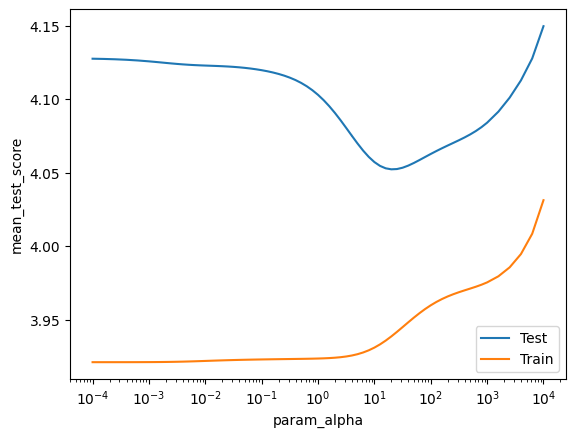

In [49]:
sns.lineplot(x="param_alpha", y="mean_test_score", data=cv_results_, label="Test")
sns.lineplot(x="param_alpha", y="mean_train_score", data=cv_results_, label="Train")
plt.xscale("log")
plt.show()

In [50]:
mejor = gs.best_estimator_
mostrar_rmse(mejor, X_train4, y_train, model_matrix(formula, X_test), y_test)

# RMSE
Train: 3.9485
Test:  3.9684


In [51]:
formula_real = "~ poly(a, 2, raw=True) + poly(b, 2, raw=True) + a:b"
X_real = model_matrix(formula_real, data=X_train)
lr_real = LinearRegression()
lr_real.fit(X_real, y_train)
mostrar_rmse(lr_real, X_real, y_train, model_matrix(formula_real, X_test), y_test)

# RMSE
Train: 3.9622
Test:  3.9495


In [52]:
betas(lr_real, X_real).round(3)

Intercept   -7.925
a            3.219
a^2         -0.803
b           -1.042
b^2          0.578
a:b          1.487
dtype: float64

Los coeficientes originales eran:
$$ y = 1 + 3a - 2b + 1.5 ab - 0.8 a^2 - 0.6 b^2 + \epsilon$$

Entonces, ¿es cierta la hipótesis? ¿Da lo mismo un modelo "genérico" con regularización que un modelo "ad-hoc"? ¿En qué tipo de tareas?

## Consigna

Cargue el dataset `wine` de scikit-learn, e intente predecir el contenido de alcohol (`alcohol`) de cada vino, usando las características a su disposición, usando una regresión Ridge sobre una matriz de diseño sesudamente construida.

NOTA: El dataset está preparado para utilizarlo en problemas de clasificación, así que tendrá que trocar el objetivo ("target") con la variable predictora "alcohol". Note que la etiqueta del vino peude ser de utilidad en el diseño del modelo.

In [53]:
from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)

In [54]:
dir(wine)  # estos son los atributos del objeto, exprorelos!

['DESCR', 'data', 'feature_names', 'frame', 'target', 'target_names']

## Bonus: Pipelines, Transformers y cómo tratar el grado del polinomio como un hiperparámetro.

In [55]:
from typing import Iterable, List, Optional

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from formulaic import Formula, FormulaSpec, ModelSpec


class FormulaicTransformer(TransformerMixin, BaseEstimator):

    def __init__(self, formula: Formula):
        self.formula: Formula = Formula.from_spec(formula)
        self.model_spec: Optional[ModelSpec] = None
        if self.formula._has_structure:
            raise ValueError(
                f"Formula specification {repr(formula)} results in a structured formula, which is not supported."
            )

    def fit(self, X, y=None):
        """
        Generate the initial model spec by which subsequent X's will be
        transformed.
        """
        self.model_spec = self.formula.get_model_matrix(X).model_spec
        return self

    def transform(self, X, y=None):
        """
        Transform `X` by generating a model matrix from it based on the fit
        model spec.
        """
        if self.model_spec is None:
            raise RuntimeError(
                "`FormulaicTransformer.fit()` must be called before `.transform()`."
            )
        X_ = self.model_spec.get_model_matrix(X)
        return X_

    def get_feature_names_out(
        self, input_features: Optional[Iterable[str]] = None
    ) -> List[str]:
        """
        Expose model spec column names to scikit learn to allow column transforms later in the pipeline.
        """
        if self.model_spec is None:
            raise RuntimeError(
                "`FormulaicTransformer.fit()` must be called before columns can be assigned names."
            )
        return self.model_spec.column_names


pipe = Pipeline(
    [("formula", FormulaicTransformer("x1 + x2 + x3")), ("model", LinearRegression())]
)
pipe_fit = pipe.fit(
    pd.DataFrame({"x1": [1, 2, 3], "x2": [2, 3.4, 6], "x3": [7, 3, 1]}),
    y=pd.Series([1, 3, 5]),
)
pipe_fit
# Note: You could optionally serialize `pipe_fit` here.
# Then: Use the pipe to predict outcomes for new data.

Pipeline(steps=[('formula', FormulaicTransformer(formula=1 + x1 + x2 + x3)),
                ('model', LinearRegression())])

In [56]:
pipe = Pipeline(
    [
        ("pre", FormulaicTransformer("~a * b")),
        ("est", LinearRegression(fit_intercept=False)),
    ]
)

In [57]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('pre', FormulaicTransformer(formula=1 + a + b + a:b)),
                ('est', LinearRegression(fit_intercept=False))])

In [58]:
mostrar_rmse(pipe, X_train, y_train, X_test, y_test)

# RMSE
Train: 24.5622
Test:  24.8076


In [59]:
formulas = {
    grado: Formula(f"~ 0 + poly(a, {grado}, raw=True) * poly(b, {grado}, raw=True)")
    for grado in range(1, 8)
}
param_grid = {
    "pre__formula": list(formulas.values()),
}
gs = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    error_score="raise",
    return_train_score=True,
)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('pre',
                                        FormulaicTransformer(formula=1 + a + b + a:b)),
                                       ('est',
                                        LinearRegression(fit_intercept=False))]),
             param_grid={'pre__formula': [poly(a, 1, raw=True) + poly(b, 1, raw=True) + poly(a, 1, raw=True):poly(b, 1, raw=True),
                                          poly(a, 2, raw=True) + poly(b, 2, raw=True) + poly(a, 2, raw=True):poly(b, 2, raw=True),
                                          poly(a, 3, r...
                                          poly(a, 4, raw=True) + poly(b, 4, raw=True) + poly(a, 4, raw=True):poly(b, 4, raw=True),
                                          poly(a, 5, raw=True) + poly(b, 5, raw=True) + poly(a, 5, raw=True):poly(b, 5, raw=True),
                                          poly(a, 6, raw=True) + poly(b, 6, raw=True) + poly(a, 6, raw=True):poly(b, 6, raw=True),
                                          poly(a, 7, raw=True) + poly(b, 7, raw=True) + poly(a, 7, raw=True):poly(b, 7, raw=True)]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

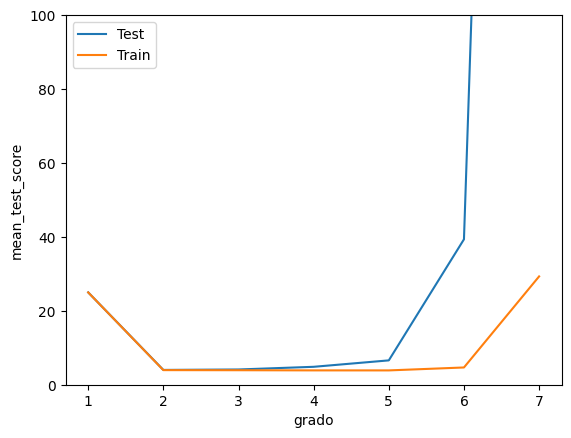

In [60]:
cv_results_ = -pd.DataFrame(gs.cv_results_)[["mean_test_score", "mean_train_score"]]
cv_results_["grado"] = list(formulas.keys())
sns.lineplot(x="grado", y="mean_test_score", data=cv_results_, label="Test")
sns.lineplot(x="grado", y="mean_train_score", data=cv_results_, label="Train")
plt.ylim(0, 100)
plt.show()

Fíjense qué rápido se va al demonio el error en Test de un polinomio con gado demasiado alto. También: por qué será que el error de entrenamiento _también_ sube con el grado del polinomio?

In [61]:
gs.best_params_

{'pre__formula': poly(a, 2, raw=True) + poly(b, 2, raw=True) + poly(a, 2, raw=True):poly(b, 2, raw=True)}

In [62]:
betas(
    gs.best_estimator_.named_steps["est"],
    gs.best_estimator_.named_steps["pre"].transform(X_train),
)

a          0.533610
a^2       -0.669098
b         -2.499565
b^2        0.642372
a:b        1.986855
a^2:b     -0.025035
a:b^2     -0.022269
a^2:b^2    0.001119
dtype: float64

$$ y = 1 + 3a - 2b + 1.5 ab - 0.8 a^2 - 0.6 b^2 + \epsilon$$

In [63]:
pipe = Pipeline([
    ("pre", FormulaicTransformer("~ 0 + a * b")),
    ("est", Ridge())
])
param_grid = {
    "pre__formula": list(formulas.values())[:5],
    "est__alpha": np.logspace(-1, 3, 20)
}
gs2 = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    error_score="raise",
    return_train_score=True,
)
gs2.fit(X_train, y_train)

/Users/gonzalo/Git/ldd/venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.56261e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/gonzalo/Git/ldd/venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.06326e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/gonzalo/Git/ldd/venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.16328e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/gonzalo/Git/ldd/venv/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.25558e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/gonzalo/Git/l

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('pre',
                                        FormulaicTransformer(formula=a + b + a:b)),
                                       ('est', Ridge())]),
             param_grid={'est__alpha': array([1.00000000e-01, 1.62377674e-01, 2.63665090e-01, 4.28133240e-01,
       6.95192796e-01, 1.12883789e+00, 1.83298071e+00, 2.97635144e+00,
       4.83293024e+00, 7.84759970e+00, 1.27427499e+01, 2.06913808e+01,
       3.35981829...
                                          poly(a, 2, raw=True) + poly(b, 2, raw=True) + poly(a, 2, raw=True):poly(b, 2, raw=True),
                                          poly(a, 3, raw=True) + poly(b, 3, raw=True) + poly(a, 3, raw=True):poly(b, 3, raw=True),
                                          poly(a, 4, raw=True) + poly(b, 4, raw=True) + poly(a, 4, raw=True):poly(b, 4, raw=True),
                                          poly(a, 5, raw=True) + poly(b, 5, raw=True) + poly(a, 5, raw=True):poly(b, 5, raw=True)]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

Fíjense qué rápido se va al demonio el error en Test de un polinomio con gado demasiado alto. También: por qué será que el error de entrenamiento _también_ sube con el grado del polinomio?

In [64]:
gs2.best_params_

{'est__alpha': 4.832930238571752,
 'pre__formula': poly(a, 2, raw=True) + poly(b, 2, raw=True) + poly(a, 2, raw=True):poly(b, 2, raw=True)}

In [65]:
betas(
    gs2.best_estimator_.named_steps["est"],
    gs2.best_estimator_.named_steps["pre"].transform(X_train),
)

a            1.069749
a^2         -0.667133
b           -1.110648
b^2          0.588534
a:b          1.900460
a^2:b       -0.025277
a:b^2       -0.018940
a^2:b^2      0.001129
Intercept   -8.705824
dtype: float64

$$ y = 1 + 3a - 2b + 1.5 ab - 0.8 a^2 - 0.6 b^2 + \epsilon$$

In [66]:
mostrar_rmse(gs, X_train, y_train, X_test, y_test)

# RMSE
Train: 3.9568
Test:  3.9581


In [67]:
mostrar_rmse(gs2, X_train, y_train, X_test, y_test)

# RMSE
Train: 3.9568
Test:  3.9632
